Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 16)         2320

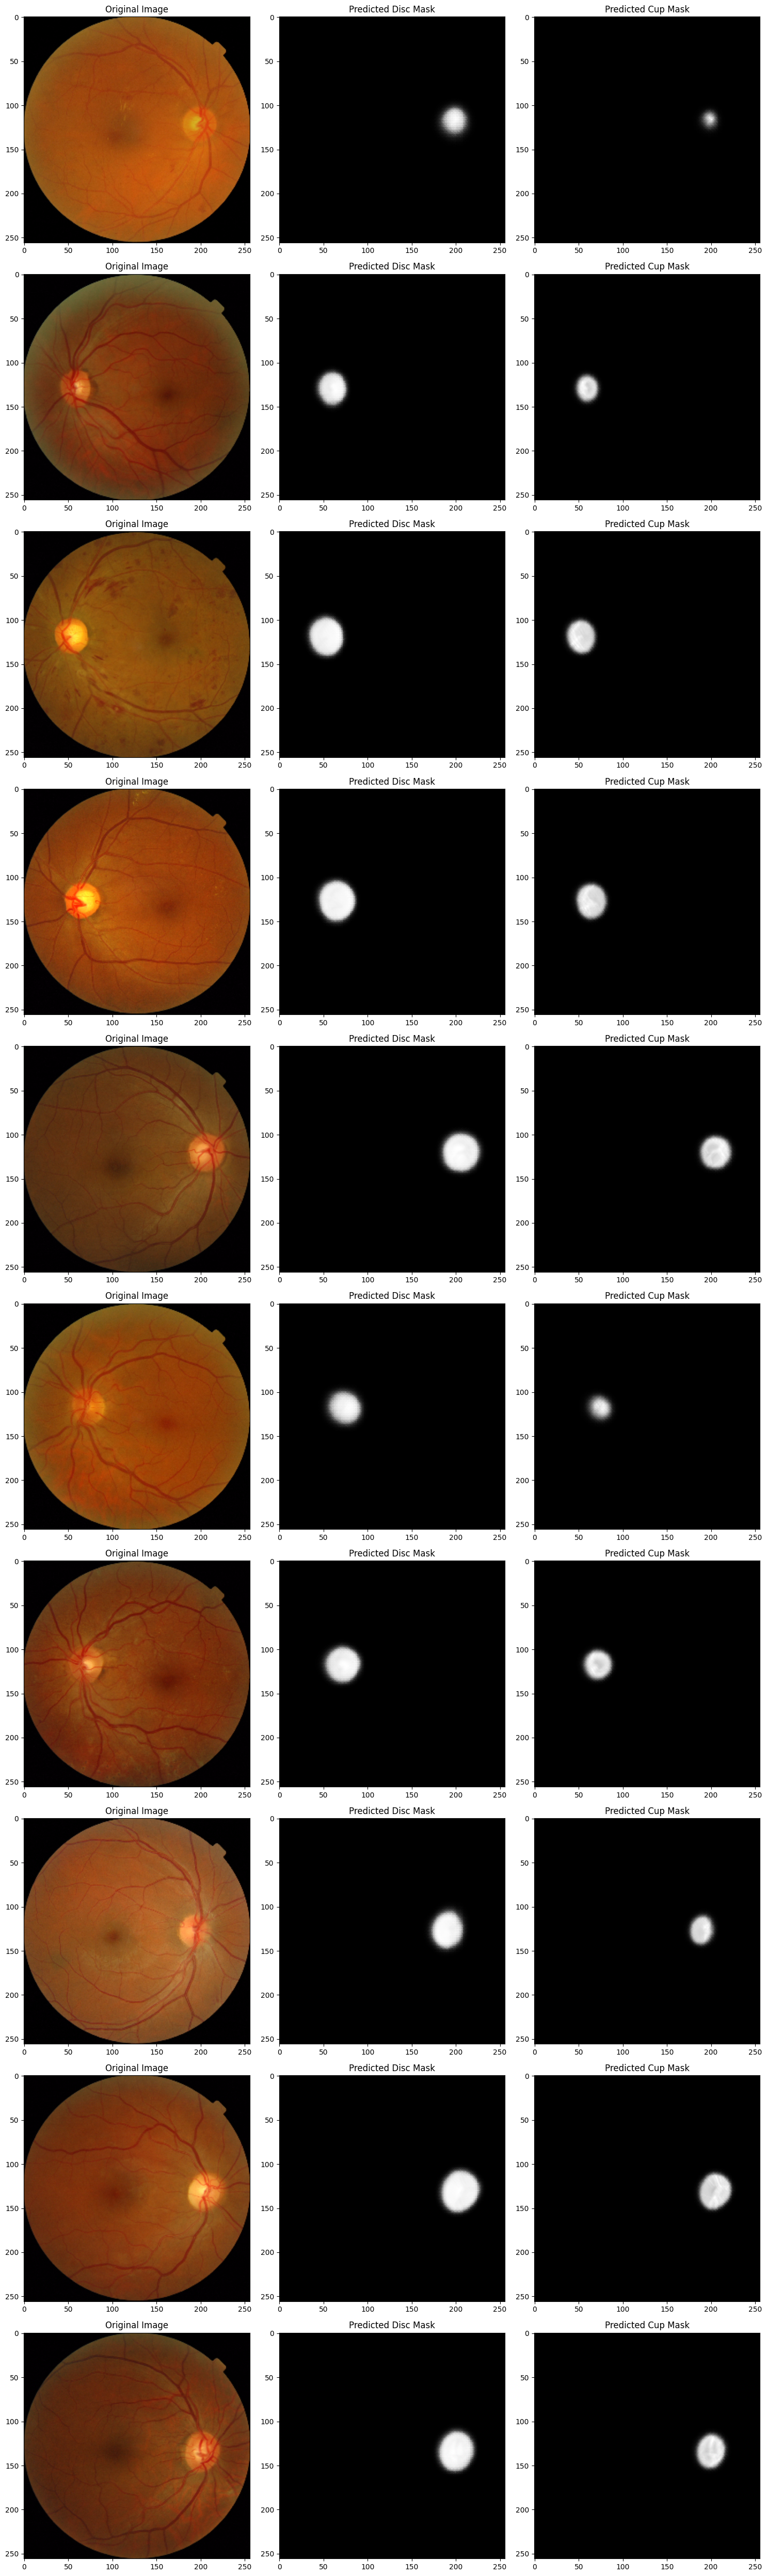

Calculated CDR: 0.0


In [ ]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

def load_data(image_dir):
    images = []
    masks = []
    for filename in sorted(os.listdir(image_dir)):
        if filename.endswith('.png'):
            img = cv2.imread(os.path.join(image_dir, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))
            images.append(img)
        elif filename.endswith('.tif'):
            mask = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (256, 256))

            disc_mask = (mask > 0).astype(np.float32)
            cup_mask = (mask == 255).astype(np.float32)
            combined_mask = np.stack((disc_mask, cup_mask), axis=-1)
            masks.append(combined_mask)

    images = np.array(images) / 255.0
    masks = np.array(masks)
    return images, masks

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Contracting Path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(2, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])

    return model


def create_augmentation():
    data_gen_args = dict(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    return image_datagen, mask_datagen

image_dir = '/content/drive/My Drive/RIGA 200 Images/'
images, labels = load_data(image_dir)

x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

image_datagen, mask_datagen = create_augmentation()
image_generator = image_datagen.flow(x_train, batch_size=16, seed=42)
mask_generator = mask_datagen.flow(y_train, batch_size=16, seed=42)
train_generator = zip(image_generator, mask_generator)

model = build_unet((256, 256, 3))
model.summary()

checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

results = model.fit(train_generator, steps_per_epoch=(len(x_train) // 16), epochs=50, validation_data=(x_val, y_val), callbacks=[checkpoint_cb, early_stopping_cb])



Index: normal (0 ≤ CDR ≤ 0.5); moderate (0.5 ≤ CDR ≤ 0.8); and severely glaucomatous (0.8 ≤ CDR ≤ 1)

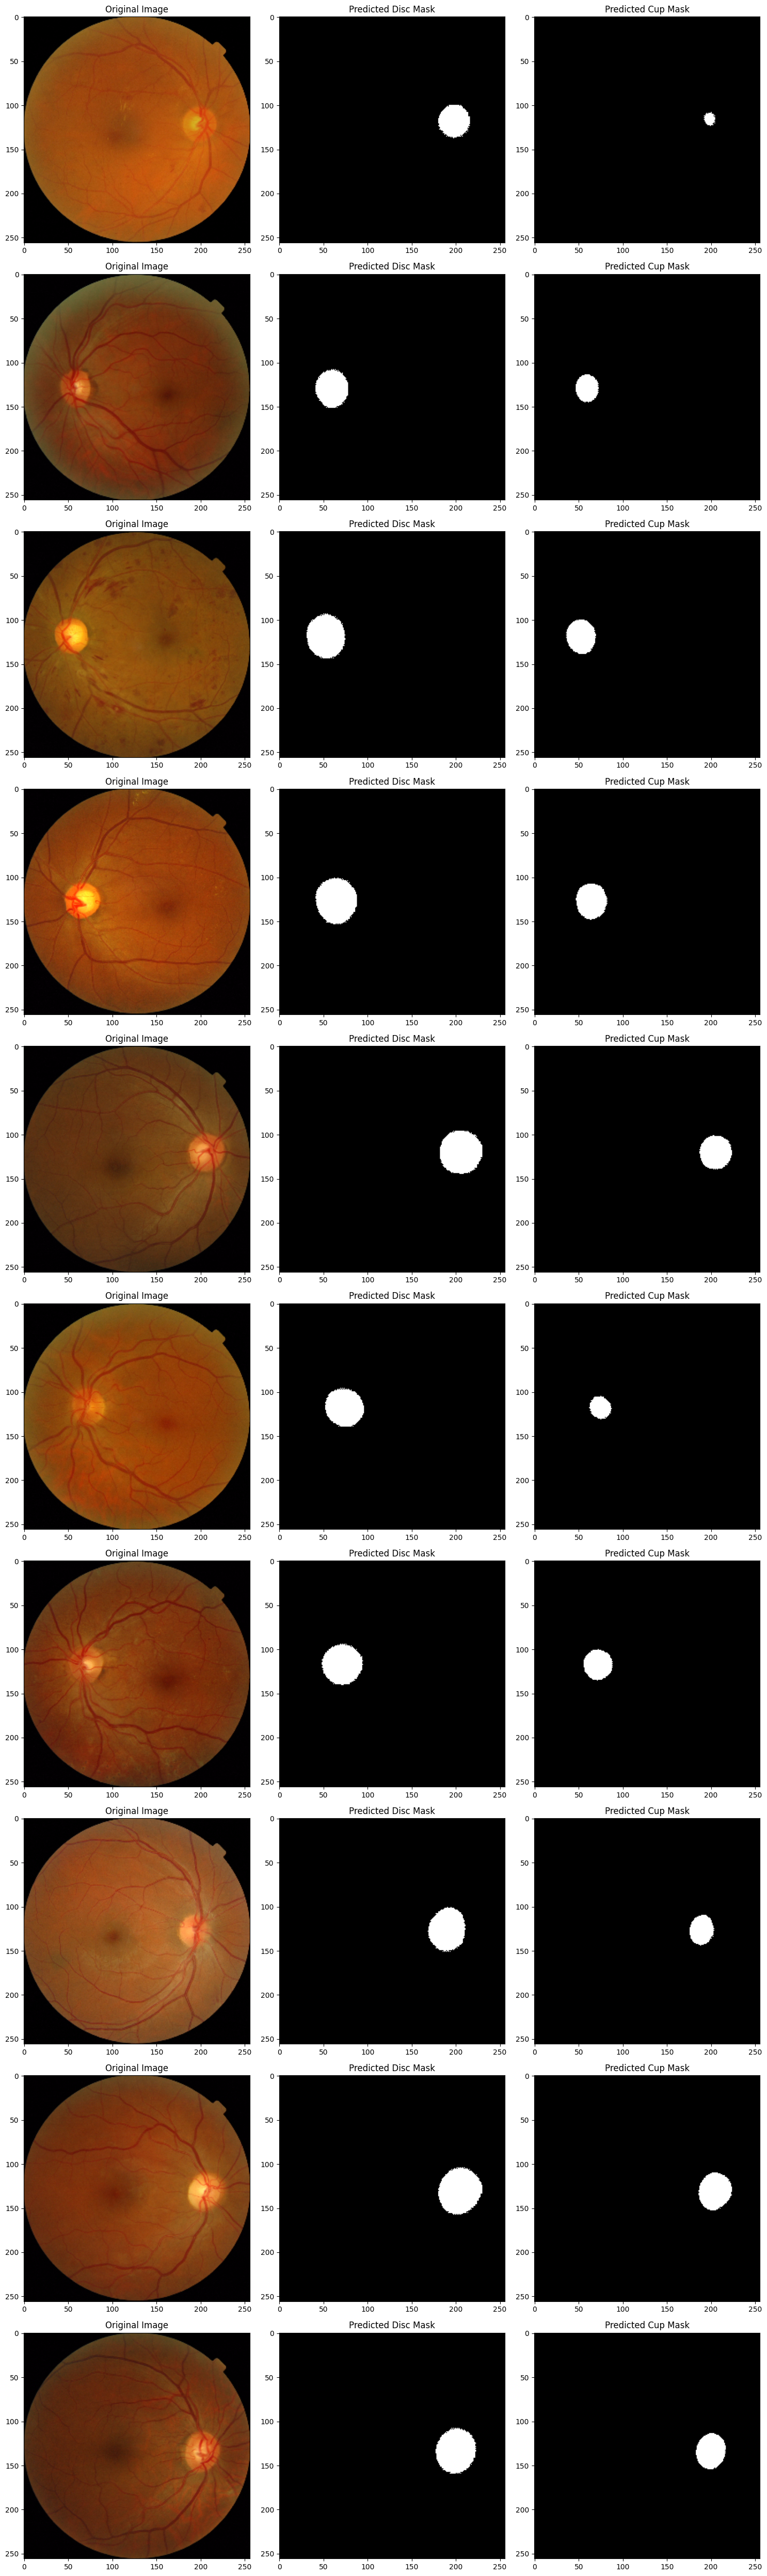

Image 1:
  Disc white pixels: 1042
  Cup white pixels: 144
  Calculated CDR: 0.1381957773512476
  Classification: Normal

Image 2:
  Disc white pixels: 1259
  Cup white pixels: 645
  Calculated CDR: 0.5123113582208102
  Classification: Moderate

Image 3:
  Disc white pixels: 1722
  Cup white pixels: 1020
  Calculated CDR: 0.5923344947735192
  Classification: Moderate

Image 4:
  Disc white pixels: 1912
  Cup white pixels: 1122
  Calculated CDR: 0.5868200836820083
  Classification: Moderate

Image 5:
  Disc white pixels: 1889
  Cup white pixels: 1107
  Calculated CDR: 0.5860243515087348
  Classification: Moderate

Image 6:
  Disc white pixels: 1495
  Cup white pixels: 486
  Calculated CDR: 0.3250836120401338
  Classification: Normal

Image 7:
  Disc white pixels: 1644
  Cup white pixels: 889
  Calculated CDR: 0.5407542579075426
  Classification: Moderate

Image 8:
  Disc white pixels: 1621
  Cup white pixels: 729
  Calculated CDR: 0.4497223935842073
  Classification: Normal

Image 9:
  

In [ ]:
def plot_masks(images, predicted_masks, threshold=0.5):
    fig, axes = plt.subplots(len(images), 3, figsize=(15, 5 * len(images)))
    for i, (img, mask) in enumerate(zip(images, predicted_masks)):
        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Original Image')
        axes[i, 1].imshow(mask[..., 0] > threshold, cmap='gray')
        axes[i, 1].set_title('Predicted Disc Mask')
        axes[i, 2].imshow(mask[..., 1] > threshold, cmap='gray')
        axes[i, 2].set_title('Predicted Cup Mask')
    plt.tight_layout()
    plt.show()

def count_white_pixels(mask, threshold=0.5):
    return np.sum(mask > threshold)

def classify_cdr(cdr):
    if cdr <= 0.5:
        return "Normal"
    elif cdr <= 0.8:
        return "Moderate"
    elif cdr <= 1:
        return "Severely Glaucomatous"
    else:
        return "Undefined"


plot_masks(x_val, predicted_masks, threshold=0.1)

cdr_values = []
classification_results = []
for index, mask_set in enumerate(predicted_masks):
    disc_white_pixels = count_white_pixels(mask_set[..., 0], threshold=0.1)
    cup_white_pixels = count_white_pixels(mask_set[..., 1], threshold=0.1)
    cdr = (cup_white_pixels / disc_white_pixels) if disc_white_pixels != 0 else 0
    classification = classify_cdr(cdr)
    cdr_values.append(cdr)
    classification_results.append(classification)
    print(f"Image {index + 1}:")
    print(f"  Disc white pixels: {disc_white_pixels}")
    print(f"  Cup white pixels: {cup_white_pixels}")
    print(f"  Calculated CDR: {cdr}")
    print(f"  Classification: {classification}\n")